In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt

The concept of this method is that per each iteration of data collection when the latest price data becomes available, the classifier will have one extra input variable. That being that there will be a number of classifiers with differing input variables which is dependent on the number of data points available. Therefore, we want to replicate this in our model building. So for this we will apply a ML method iteratively where for each iteration there will be one new price point which the classifier will use to label the data. This will be done for all selections within a number of events.

Note that the data used here is dummy data based on data supplied by Betfair and processed via Betfair lightweight. The reason for doing this is so not to infringed on a copy right.

In [2]:
#First load in each of your csv and add to a list. We are only considering pre-start of event price therefore 
#ensure only to consider where inplay is false (note that you may also want to remove when the market is suspended).Convert time 
#column to pd.totime and ensure Time column is in order by sorting columns in terms of time. Remove prices of 
#1000.00 and 1.01 as these are for the starting price which is a different market.

df_list = []

directory = os.path.join("/Users/Sandy/Desktop/GitHub")
for root,dirs,files in os.walk(directory):
    for file in files:
        if file.endswith(".csv"):
            f=open(file, 'r')
            df = pd.read_csv(file)
            
            df = df[df["Inplay"] == False]
            
            df['Time'] = pd.to_datetime(df['Time'])

            df = df.sort_values('Time')
            
            df = df[df["LastPriceTraded"] < 1000.00]
            df = df[df["LastPriceTraded"] > 1.01]

            df_list.append(df)
            f.close()

In [3]:
#Get the max length out of all the .csv files, which represent each market. This is used in the next step to build
#the size of each iteration.

len_list = []
            
for df_len in df_list:
    len_value = len(df_len)
    len_list.append(len_value)
            
l = [None] * max(len_list)

In [4]:
#Let's split this up into a list of lists where each iteration of the inner list has a length of value one larger 
#than the previous up until the largest length of each event.

builder_list = []

counter = 0

for x in l:
    
    l_new = l[0: counter + 1]
    
    builder_list.append(l_new)
    
    counter = counter + 1

In [5]:
#For each event get the unique number of runners and make a separate dataframe for each runner. By one step
#itteratively go through each of the new dataframes and convert the price to a list and append this to the builder
#list where each inner list is converted to a numpy array.

dataframelist  = []

number_of_runners_per_event = []

for event in df_list:

    runners = []

    runners = event['SelectionId'].unique().tolist()
    
    number_of_runners = len(runners)
    
    number_of_runners_per_event.append(number_of_runners)
    
    for selection in runners:

        df_new = event[event['SelectionId'] == selection]

        dataframelist.append(df_new)
        
    count_time_stamp = 0
    
    list_all_odds = []
    
    for time_stamp in builder_list:
        
        count_time_stamp = count_time_stamp + 1
        
        list_price_2 = []
        
        for runner in dataframelist:
            
            new_list_price = runner['LastPriceTraded'].iloc[:count_time_stamp].tolist()
            
            new_list_price = np.asarray(new_list_price, dtype=np.float32)
            
            list_all_odds.append(new_list_price)

In [6]:
#Take each numpy array of equal length and vstack these. These are then used as the input for the classifier.

list_all_odds_sorted = []

sum_of_events = sum(number_of_runners_per_event)

count_array = -sum_of_events

list_all_odds_sorted = []

sum_of_events = sum(number_of_runners_per_event)

count_array = -sum_of_events

for z in l:
    
    try:
        
        count_array = count_array + sum_of_events
        
        new_list_all_odds = list_all_odds[count_array:count_array + sum_of_events]
        
        new_list_all_odds = np.vstack(new_list_all_odds)
        list_all_odds_sorted.append(new_list_all_odds)
        
    except:
        pass

In [7]:
#We now need to label the data. To do this we need to look at the last value of next element for each element of 
#the list_all_odds_sorted list. For the last element or erroneous value an nan term is added. This will be removed
#before training the model. This is stored as a numpy array within a list. We want to remove the last row as we 
#are not able to assign a label for this.

counter = 0

final_up_down_equals_list = []

for z in list_all_odds_sorted:
    
    up_down_equals_list = []
    
    if counter < len(list_all_odds_sorted) - 1:
    
        comparison_array = list_all_odds_sorted[counter + 1]

        counter = counter + 1

        for comparison in comparison_array:

            try:

                if comparison[-1] > comparison[-2]:
                    direction = 1

                if comparison[-1] == comparison[-2]:
                    direction = 0

                if comparison[-1] < comparison[-2]:
                    direction = -1

                up_down_equals_list.append(direction)

                up_down_equals_list_new = np.asarray(up_down_equals_list, dtype=np.float32)

            except:

                direction = float('Nan')

                up_down_equals_list.append(direction)

                up_down_equals_list_new = np.asarray(up_down_equals_list, dtype=np.float32)

        final_up_down_equals_list.append(up_down_equals_list_new)
        
    else:
        break

list_all_odds_sorted = list_all_odds_sorted[:-1]

The data has now been sorted into a number of numpy arrays which has one extra column per iteration. This has also been assigned a label based on if the next value is higher equal to or lower than the last value in that array. It is therefore now possible to build a predictive model. An example of this is outlined below. On top of this we really want to see how accurate we are at predicting price movements as this is what we can exploit. Therefore, I have added some lines of code that aggerate the data in terms if it accurately predicted up, no movement, down or if this was erroneously predicted. This has then been plotted on a histogram.

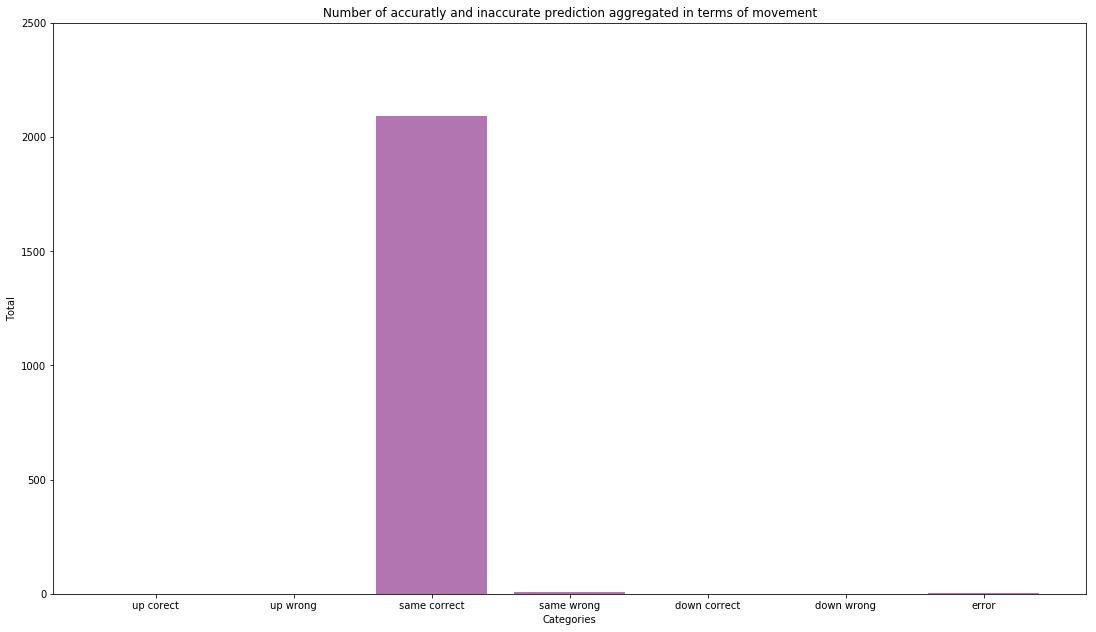

In [8]:
knn = KNeighborsClassifier(n_neighbors = 6)

counter_accurately_predict_up = 0
counter_not_accurately_predict_up = 0

counter_accurately_predict_same = 0
counter_not_accurately_predict_same = 0

counter_accurately_predict_down = 0
counter_not_accurately_predict_down = 0

counter_error = 0

counter_prediction = 1

counter_prediction_1 = 1

counter_prediction_2 = 2

counter_odds_sorter = -1

for prediction in list_all_odds_sorted:
    
    if counter_prediction < len(list_all_odds_sorted) - 1:

        knn.fit(list_all_odds_sorted[counter_prediction], final_up_down_equals_list[counter_prediction])

        counter_prediction = counter_prediction + 1

        X_train, X_test, y_train, y_test = train_test_split(list_all_odds_sorted[counter_prediction], 
                                                                final_up_down_equals_list[counter_prediction], 
                                                                test_size = 0.3, random_state = 21)

        knn = KNeighborsClassifier(n_neighbors = 6)

        knn.fit(X_train, y_train)

        y_pred = knn.predict(X_test)

        comparison_list = []

        len_X_test = 0

        for ml in X_test:

            counter_prediction_1 = counter_prediction_1 + 1

            len_X_test = len_X_test + 1

            if len_X_test == len(X_test) - 1:


                complete = list_all_odds_sorted[counter_prediction_2]

                counter_prediction_2 = counter_prediction_2 + 1

            if len_X_test < len(X_test) - 1:

                complete = list_all_odds_sorted[counter_prediction_2]

            for selection_price_movement in complete:

                comparison = ml == selection_price_movement
                equal_arrays = comparison.all()

                if equal_arrays == True:

                    index_value = np.where(complete == ml)

                    index_value = index_value[0][0]

                    break

                else:
                    continue
                    
            try:

                if len_X_test == len(X_test) - 1:

                    previous_price = list_all_odds_sorted[counter_prediction_2][index_value][-2]
                    current_price = list_all_odds_sorted[counter_prediction_2][index_value][-1]
                
                if len_X_test < len(X_test) - 1:

                    previous_price = list_all_odds_sorted[counter_prediction_2 + 1][index_value][-2]
                    current_price = list_all_odds_sorted[counter_prediction_2 + 1][index_value][-1]
                    
                if previous_price < current_price:
                    compairson_price = 1

                if previous_price == current_price:
                    compairson_price = 0

                if previous_price > current_price:
                    compairson_price = -1
                    
            except:
                compairson_price = 2

            comparison_list.append(compairson_price)

        counter_pred = 0 

        for pred in y_pred:
            true_result = comparison_list[counter_pred]

            if pred == 1 and true_result == 1:
                counter_accurately_predict_up = counter_accurately_predict_up + 1

            if pred == 1 and true_result != 1:
                counter_not_accurately_predict_up = counter_not_accurately_predict_up + 1

            if pred == 0 and true_result == 0:
                counter_accurately_predict_same = counter_accurately_predict_same + 1

            if pred == 0 and true_result != 0:
                counter_not_accurately_predict_same = counter_not_accurately_predict_same + 1

            if pred == -1 and true_result == -1:
                counter_accurately_predict_down = counter_accurately_predict_down + 1

            if pred == -1 and true_result != -1:
                counter_not_accurately_predict_down = counter_not_accurately_predict_down + 1
                
            if true_result == 2:
                counter_error = counter_error + 1

            counter_pred = counter_pred + 1

    else:

        break

height = [counter_accurately_predict_up, counter_not_accurately_predict_up, counter_accurately_predict_same, 
    counter_not_accurately_predict_same, counter_accurately_predict_down, counter_not_accurately_predict_down,
    counter_error]
bars = ('up corect', 'up wrong', 'same correct', 'same wrong', 'down correct','down wrong','error')

y_pos = np.arange(len(bars))
 
plt.bar(y_pos, height, color = (0.5,0.1,0.5,0.6))
 
plt.title('Number of accuratly and inaccurate prediction aggregated in terms of movement')
plt.xlabel('Categories')
plt.ylabel('Total')
 
plt.ylim(0,2500)
 
plt.xticks(y_pos, bars)

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(18.5, 10.5, forward=True)
 
plt.show()

This as a dataset is not extensive therefore no real meaning can be extracted from the analysis. Though it does show a method in which to sort the data and make this useable for the scikit-learn library. There is also significant scope, excluding the increase the volume data used, to increase the accuracy of the classifier. This include using a different classifier method, changing the boundary in which to assign a label and using data with more information such as volume traded at that price. Despite this, this is a good starting point to carry our further analysis.